# Ui-Wing Cheah
## EN 625.633 Final Exam


In [3]:
# import statements
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

### General functions and objects

In [95]:
# function to do metropolis-hastings sampling
def metro_hast(f_pdf, g_pdf, g_gen,ndraws = 100,init_value = None, *args,**kwargs):
    ### function to run the general metropolis-hastings algorithm
    ### inputs
    ### f_pdf: a function that returns the pdf f(x)
    ### g_pdf: a function that returns the candidate value g(x_1|x_0)
    ### g_gen: a function that returns a random variable drawn from g(x_1|x_0)
    ### n_samples: the number of samples we want to generate from
    sim_samples = g_gen(ndraws,*args,**kwargs)
    
    # allow for an initialization value if provided 
    if init_value is not None:
        sim_samples[0]=init_value
        
    # we pull all the uniform variables we need upfront
    unif_rv = sp.uniform.rvs(size=ndraws)
    acceptance = np.zeros(ndraws)
    acceptance_prob = np.zeros(ndraws)
    def accep_prob(x1,x0):
        return f_pdf(x1,x0,*args,**kwargs)*g_pdf(x0,x1,*args,**kwargs)/(f_pdf(x0,x1,*args,**kwargs)*g_pdf(x1,x0,*args,**kwargs))

    for i_sim in range(1,len(sim_samples+1)):
        y = sim_samples[i_sim]
        x = sim_samples[i_sim-1]
        p_acc = min(1,accep_prob(y,x))
        acceptance_prob[i_sim-1]=p_acc
        sim_samples[i_sim] = x+(y-x)*(unif_rv[i_sim-1]<=p_acc)
        if unif_rv[i_sim-1]<=p_acc:
            acceptance[i_sim-1]=1
                
    results = {'samples':sim_samples,'accept_rate':acceptance.sum()/ndraws, 'paccept':acceptance_prob}
    return results

def dist_plotter(dist_kernel,label='',axes_ = None,*args,**kwargs):
    # convenience function to plot a distribution (pdf) in the sp.<dist> convention
    # start by getting the ppf values
    # truncate from 0 and 1 since many continuos distributions asymptote
    x_ppf = np.linspace(0.005,0.995,1000)
    x = dist_kernel.ppf(x_ppf)
    y = dist_kernel.pdf(x)
    ax_ = sns.lineplot(x=x,y=y,label=label,ax=axes_)
    return ax_




### Problem 1

In [13]:
def f_p1_pdf(x,*args,**kwargs):
    return sp.t(df=4).pdf(x)

def g_norm_pdf(x,*args,**kwargs):
    dist = sp.norm(loc=0,scale=1)
    return dist.pdf(x)

def g_norm_gen(nobs,*args,**kwargs):
    dist = sp.norm(loc=0,scale=1)
    return dist.rvs(size=nobs)

def g_t_pdf(x,*args,**kwargs):
    dist = sp.t(df=2)
    return dist.pdf(x)

def g_t_gen(nobs,*args,**kwargs):
    dist = sp.t(df=2)
    return dist.rvs(size=nobs)
    

Text(0, 0.5, 'f(x)')

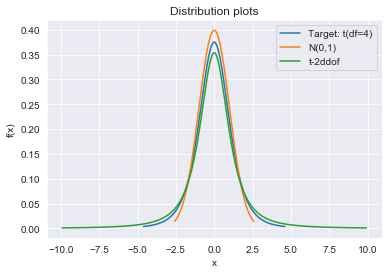

In [19]:
# student t
t_dist = sp.t(df=4)
n_dist = sp.norm(loc=0,scale=1)
t_dist_2 = sp.t(df=2)
ax_ = dist_plotter(t_dist,label='Target: t(df=4)')
ax_ = dist_plotter(n_dist,label='N(0,1)',axes_=ax_)
ax_ = dist_plotter(t_dist_2,label='t-2ddof',axes_=ax_)
ax_.set_title('Distribution plots')
ax_.set_xlabel('x')
ax_.set_ylabel('f(x)')


Empirical mean from 1000 samples: -0.0400


Text(0, 0.5, 'Frequency/f(x)')

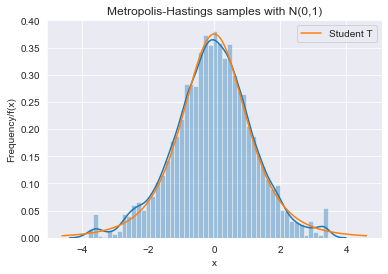

In [109]:
# running Metropolis-Hastings for part (a)
np.random.seed(1000)
results_1a = metro_hast(f_p1_pdf,g_norm_pdf,g_norm_gen,ndraws=10000,)
print('Empirical mean from 1000 samples: {0:.4f}'.format(results_1a['samples'].mean()))
ax_1a = sns.distplot(results_1a['samples'])
ax_1a = dist_plotter(t_dist,label='Student T', axes_=ax_1a)
ax_1a.set_title('Metropolis-Hastings samples with N(0,1)')
ax_1a.set_xlabel('x')
ax_1a.set_ylabel('Frequency/f(x)')

Empirical mean from 1000 samples: -0.0168


Text(0, 0.5, 'Frequency/f(x)')

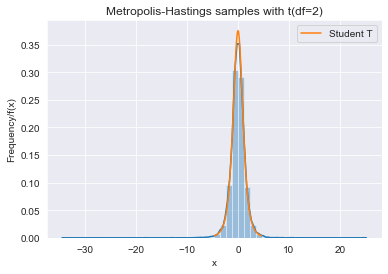

In [110]:
np.random.seed(1000)
results_1b = metro_hast(f_p1_pdf,g_t_pdf,g_t_gen,ndraws=10000,)
print('Empirical mean from 1000 samples: {0:.4f}'.format(results_1b['samples'].mean()))
ax_1b = sns.distplot(results_1b['samples'])
ax_1b = dist_plotter(t_dist,label='Student T', axes_=ax_1b)
ax_1b.set_title('Metropolis-Hastings samples with t(df=2)')
ax_1b.set_xlabel('x')
ax_1b.set_ylabel('Frequency/f(x)')

In [111]:
print('Acceptance rate with N(0,1) = {0:.2f}\nAcceptance rate with t(df=2) = {1:.2f}'.format(results_1a['accept_rate'],results_1b['accept_rate']))

Acceptance rate with N(0,1) = 0.93
Acceptance rate with t(df=2) = 0.92


In [104]:
# creating a simulation study for the acceptance rates:
ksims = [100,500,1000,5000,10000,]
accept_rates = {}
means = {}
np.random.seed(1000)
for k_ in ksims:
    norm_sim = metro_hast(f_p1_pdf,g_norm_pdf,g_norm_gen,ndraws=k_,)
    t_sim = metro_hast(f_p1_pdf, g_t_pdf,g_t_gen,ndraws=k_,)
    means[k_] = pd.Series({'norm': norm_sim['samples'].mean(),'t':t_sim['samples'].mean()})
    accept_rates[k_] = pd.Series({'norm':norm_sim['accept_rate'], 't':t_sim['accept_rate']})

results = pd.concat({'means':pd.DataFrame(means),'accept_rates':pd.DataFrame(accept_rates)})


In [105]:
results
print(results.round(decimals=4).to_latex())

\begin{tabular}{llrrrrr}
\toprule
             &   &   100   &   500   &   1000  &   5000  &   10000 \\
\midrule
means & norm &  0.1176 &  0.0052 & -0.0358 & -0.0491 &  0.0124 \\
             & t & -0.3255 & -0.0595 &  0.0278 &  0.0260 &  0.0041 \\
accept\_rates & norm &  0.9300 &  0.9580 &  0.9460 &  0.9226 &  0.9165 \\
             & t &  0.8300 &  0.9280 &  0.9110 &  0.9154 &  0.9172 \\
\bottomrule
\end{tabular}



### Problem 2

In [64]:
f_x = lambda x,b: 4/(pow(b,3)*np.sqrt(np.pi))*pow(x,2)*np.exp(-pow(x,2)/pow(b,2))
h_x = lambda x,b: 4/(pow(b,3)*np.sqrt(np.pi))*pow(x,4)*np.exp(-pow(x,2)/pow(b,2))
g_dist = sp.gamma(a=5,scale=0.5)
g_x = lambda x: g_dist.pdf(x)
u_dist = sp.uniform(loc=1,scale=3)
u_x = lambda x: u_dist.pdf(x)


Text(0, 0.5, 'f(x)')

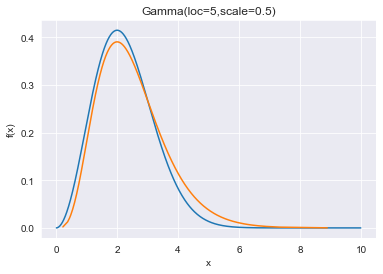

In [58]:
# plotting distriution function
x = np.arange(start=0.01,stop=10,step=0.01)
y = f_x(x,2)
ax_p2 = sns.lineplot(x=x,y=y)

# plot a gamma function
dist_x = sp.gamma(a=5,scale=0.5)
x = dist_x.ppf(np.linspace(0.0001,0.9999,1000))
y = dist_x.pdf(x)
ax_p2= sns.lineplot(x=x,y=y,ax=ax_p2)
ax_p2.set_title('Gamma(loc=5,scale=0.5)')
ax_p2.set_xlabel('x')
ax_p2.set_ylabel('f(x)')

In [63]:
# calculatng the integral for E(X^2) - h(x)
rand_var = g_dist.rvs(size=1000)
hx_int = np.mean(h_x(rand_var,2)/g_x(rand_var))
print(hx_int)

5.725650841292199


In [72]:
# Use a uniform distribution 
unif_var = u_dist.rvs(size=1000)
f_int = np.mean(f_x(unif_var,2)/u_x(unif_var))
print(f_int)

0.8719375454328109
